# Here starts the eval script with debugging

In [3]:
import argparse
import copy
import math
import sys,os
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm
import flows as fnn

from eval_model import eval_model
from data_loader import load_dataset, load_data # detta är från en separat fil, data_loader.py

In [4]:
innermodel="10_epochs/inner_withsig_epoch_9_Model.par"
outermodel="10_epochs/outer_withsig_epoch_9_Model.par"
datashift=0

# model parameters
flow='maf'
num_blocks = 15
num_hidden = 128
lr = 1e-4

print('MAF pars',num_blocks,num_hidden)

MAF pars 15 128


In [8]:
CUDA = False
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}

# panda läser h5-filer
features_sig=pd.read_hdf("LHCORD_sig_features.h5")
features_bg=pd.read_hdf("LHCORD_qcd_features.h5")

# load_data definieras i data_loader.py och returnerar följande:
# np.dstack((mjj/1000,mjmin/1000,(mjmax-mjmin)/1000,tau21min,tau21max))[0]
# Dvs, en vektor [mjj/1000,mj1/1000,(mj2-mj1)/1000,tau21J1,tau21J2]

# laddar in bakgrund och lägger till nollor på slutet av varje event, 
# för att markera det som bakgrund
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1)))) 

# laddar in signal och lägger till ettor på slutet av varje event, 
# för att markera det som signal
dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

# Concatenates signal events to background events
dataset=np.concatenate((dataset_bg[:500000],dataset_sig[:500])).astype('float32') 
dataset_test=np.concatenate((dataset_bg[500000:],dataset_sig[500:])).astype('float32') 
dataset_test_actual=np.concatenate((dataset_bg[500000:],dataset_sig[500:1000])).astype('float32') 

dataset_shifted=np.copy(dataset)
dataset_shifted[:,1]=dataset_shifted[:,1]+datashift*(dataset_shifted[:,0]-3.5)
dataset_shifted[:,2]=dataset_shifted[:,2]+datashift*(dataset_shifted[:,0]-3.5)

dataset_test_shifted=np.copy(dataset_test)
dataset_test_shifted[:,1]=dataset_test_shifted[:,1]+datashift*(dataset_test_shifted[:,0]-3.5)
dataset_test_shifted[:,2]=dataset_test_shifted[:,2]+datashift*(dataset_test_shifted[:,0]-3.5)

dataset_test_actual_shifted=np.copy(dataset_test_actual)
dataset_test_actual_shifted[:,1]=dataset_test_actual_shifted[:,1]+datashift*(dataset_test_actual_shifted[:,0]-3.5)
dataset_test_actual_shifted[:,2]=dataset_test_actual_shifted[:,2]+datashift*(dataset_test_actual_shifted[:,0]-3.5)

traindict=load_dataset(dataset_shifted)
testdict=load_dataset(dataset_test_shifted)
testdict_actual=load_dataset(dataset_test_actual_shifted)

flow='maf'
num_blocks = 15
num_hidden = 128
lr = 1e-4
num_inputs = traindict['all_tensor'].shape[-1]
num_cond_inputs = traindict['all_labels'].shape[-1]  # labels are conditional data


CUDA = False
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}

[391, 60984, 0.006411517775154139, 1.5833203876933022]
[74907, 60368, 1.2408395176252318, 304.87303217364644]
[381, 60368, 0.006311290750066261, 1.5506778439686448]


In [9]:
# Define model
act = 'relu'

modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs)
    ]

outer_model = fnn.FlowSequential(*modules)
for module in outer_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
outer_model.to(device)
            

modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs)
    ]

    
inner_model = fnn.FlowSequential(*modules)
for module in inner_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
inner_model.to(device)


print()

#latest_run="runs/Dec02_01-40-38_pascal.physics.rutgers.edumaf_LHCORD" #run with logit and standardization, using inner, larger network, SHIFTED DATASET

outer_model.load_state_dict(torch.load(outermodel, map_location='cpu'))
inner_model.load_state_dict(torch.load(innermodel, map_location='cpu'))

outer_model.eval()
inner_model.eval()


FlowSequential(
  (0): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (1): BatchNormFlow()
  (2): Reverse()
  (3): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (4): BatchNorm

In [10]:
logPfull_actual=eval_model(inner_model,testdict_actual['inner_loader'],device,
           transform=(traindict['inner_max'],traindict['inner_min'],traindict['inner_mean2'],traindict['inner_std2']))
logPbg_actual=eval_model(outer_model,testdict_actual['inner_loader'],device,
       transform=(traindict['outer_max'],traindict['outer_min'],traindict['outer_mean2'],traindict['outer_std2']))    
inner_tensor_test_actual_rescaled=(testdict_actual['inner_tensor']-traindict['inner_min'])\
    /((traindict['inner_max']-traindict['inner_min']))

In [11]:
boxcut_test_actual=np.all(inner_tensor_test_actual_rescaled.numpy()>0.05,axis=1) & \
    np.all(inner_tensor_test_actual_rescaled.numpy()<.95,axis=1) & (logPbg_actual>-2) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


### Here I find the NaNs that are still in logPbg AND logPfull

In [12]:
pbg_nans = np.argwhere(np.isnan(logPbg_actual))
pfull_nans = np.argwhere(np.isnan(logPfull_actual))
print(pbg_nans,'\n\n',pfull_nans)

[[12974]
 [34862]
 [41542]
 [47097]
 [55400]] 

 [[  338]
 [12974]
 [21654]
 [34862]
 [39402]
 [41542]
 [47097]
 [47897]
 [48402]
 [50686]
 [53114]
 [55400]
 [58828]]


In [13]:
arr = np.array([4, 5, 6, 7, 8, 9, 10, 11, 4, 5, 6, 33, 6, 7])
np.argwhere((arr >= 6) & (arr <= 10) )

array([[ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [10],
       [12],
       [13]])

In [14]:
np.delete(arr,np.argwhere((arr >= 6) & (arr <= 10) ))

array([ 4,  5, 11,  4,  5, 33])

In [15]:
pfull_nans = np.argwhere(np.isnan(logPfull_actual))

# Plot some features

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
features_sig=pd.read_hdf("LHCORD_sig_features.h5") #ladda in datafilen mha pandas
features_bg=pd.read_hdf("LHCORD_qcd_features.h5")

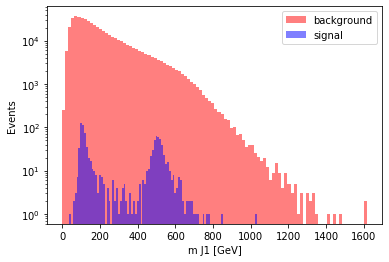

In [14]:
plt.hist(features_bg['mj1'][500000:], bins = 100, fc=(1, 0, 0, 0.5), alpha=0.5, label='background')
plt.hist(features_sig['mj1'][:1000], bins = 100, fc=(0, 0, 1, 0.5), alpha=0.5, label='signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('m J1 [GeV]')
plt.ylabel('Events')
plt.show()

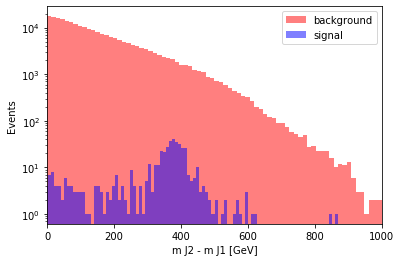

In [15]:
plt.hist((features_bg['mj2'][:500000]-features_bg['mj1'][:500000]), bins = 200, fc=(1, 0, 0, 0.5), alpha=0.5, label='background')
plt.hist((features_sig['mj2'][:1000]-features_sig['mj1'][:1000]), bins = 200, fc=(0, 0, 1, 0.5), alpha=0.5, label='signal')
plt.yscale('log')
plt.xlim(0,1000)
plt.legend(loc='upper right')
plt.xlabel('m J2 - m J1 [GeV]')
plt.ylabel('Events')
plt.show()

# Calculate R(x|m)

### Load the output from the training and exponentiate

In [17]:
pfull_actual = np.load('10_epochs/outer_withsig_epoch_9_Model.par_logPfull_actual.npy')

In [18]:
pbg_actual = np.load('10_epochs/outer_withsig_epoch_9_Model.par_logPbg_actual.npy')

In [19]:
xp_pfull=np.exp(pfull_actual)
xp_pbg=np.exp(pbg_actual)

### Isolate the signal region in the dataset 

In [20]:
dataset_bg[0,0] # First index is the row, second index gives the mJJ element

3.3072193874436437

In [21]:
# Delete all rows of dataset_test_actual where the first element is outside 
# [3.3, 3.7], and save as a new array
sr_dataset = dataset_test_actual[(dataset_test_actual[:,0] >= 3.3) & (dataset_test_actual[:,0] <= 3.7),:]

In [22]:
len(sr_dataset)

60749

In [23]:
sr_dataset_sig = sr_dataset[sr_dataset[:,5] > 0.5,:]
sr_dataset_bg = sr_dataset[sr_dataset[:,5] < 0.5,:]

In [24]:
len(sr_dataset_sig)

381

In [25]:
len(sr_dataset_bg)

60368

### Calculate R for signal and for background 

In [26]:
rx_bg=xp_pfull[0:60368]/xp_pbg[0:60368]

In [27]:
rx_sig=xp_pfull[60368:]/xp_pbg[60368:]

In [51]:
np.argwhere(np.isinf(rx_bg))

array([[34529]])

### Plot R for signal events 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


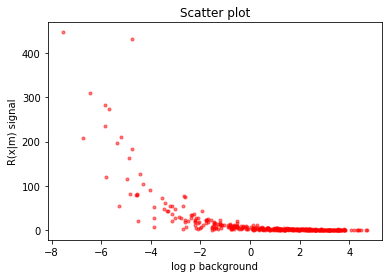

In [25]:
x = pbg_actual[60368:]
y = rx_sig
area = np.pi*3
col = (1,0,0)

# Plot
plt.scatter(x, y, s=area, c=(1,0,0), alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('log p background')
plt.ylabel('R(x|m) signal')
#plt.xlim(-2,5)
#plt.ylim(0,5)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


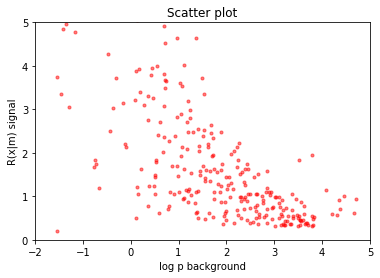

In [36]:
xs = pbg_actual[60368:]
ys = rx_sig
area = np.pi*3
col = (1,0,0)

# Plot
plt.scatter(xs, ys, s=area, c=(1,0,0), alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('log p background')
plt.ylabel('R(x|m) signal')
plt.xlim(-2,5)
plt.ylim(0,5)
plt.show()

In [29]:
logPbg_No_NaNs = np.delete(pbg_actual,pfull_nans)

In [30]:
rx_bg_No_NaNs = np.delete(rx_bg,pfull_nans)
rx_bg_No_infs = np.delete(rx_bg_No_NaNs,np.argwhere(np.isinf(rx_bg_No_NaNs)))

In [31]:
print(len(logPbg_No_NaNs),len(rx_bg_No_infs))

60736 60354


In [32]:
print(np.min(logPbg_No_NaNs),np.min(rx_bg_No_infs))
print(np.max(logPbg_No_NaNs),np.max(rx_bg_No_infs))

-2581.7258 0.0012432887
5.5224733 1946732.1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


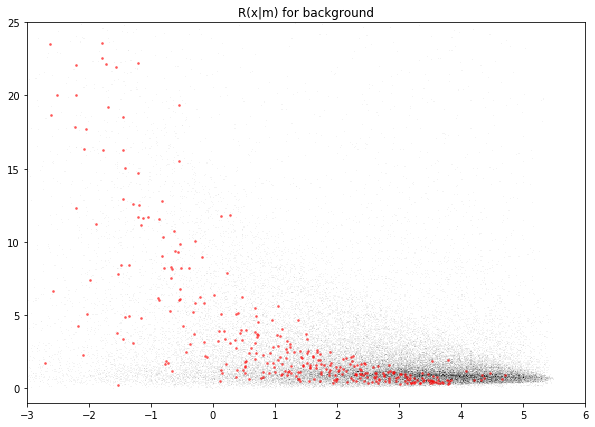

In [49]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# Creating dataset 
x = logPbg_No_NaNs[:60354]
y = rx_bg_No_infs
  
# Creating bins 
x_min = -3 
x_max = 6
  
y_min = -1 
y_max = 25 
  
x_bins = np.linspace(x_min, x_max, 500) 
y_bins = np.linspace(y_min, y_max, 500) 
  
fig = plt.subplots(figsize =(10, 7)) 
# Creating plot 
plt.hist2d(x, y, bins=[x_bins,y_bins], cmap='binary') 
plt.scatter(xs, ys, s=3, c=(1,0,0), alpha=0.5)
plt.title("R(x|m) for background") 
plt.xlim(-3,6)
plt.ylim(-1,25)
  
# show plot 
plt.show() 

# True positives etc

In [118]:
rc = np.arange(-1,25,0.1)
print(len(rc))

260


In [71]:
np.count_nonzero(rx_sig <= 1.3)

144

In [119]:
from numpy import vectorize

def func_fn(x):
     return np.count_nonzero(rx_sig <= x) # jag måste ha vänt på något här, vad som är TP osv
def func_tp(x):
     return np.count_nonzero(rx_sig > x)
    
def func_tn(x):
     return np.count_nonzero(rx_bg_No_infs <= x)
def func_fp(x):
     return np.count_nonzero(rx_bg_No_infs > x)
    
vfunc_tn = vectorize(func_tn)
vfunc_tp = vectorize(func_tp)
vfunc_fn = vectorize(func_fn)
vfunc_fp = vectorize(func_fp)

tn = vfunc_tn(rc)
print(tn[:20],len(tn))
tp = vfunc_tp(rc)
print(tp[:20],len(tp))
fn = vfunc_fn(rc)
print(fn[:20],len(fn))
fp = vfunc_fp(rc)
print(fp[:20],len(fp))

[    0     0     0     0     0     0     0     0     0     0     0   123
   511  1505  3380  6042  9074 12409 16083 20026] 260
[381 381 381 381 381 381 381 381 381 381 381 381 381 380 360 346 325 312
 299 290] 260
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 21 35 56 69 82 91] 260
[60354 60354 60354 60354 60354 60354 60354 60354 60354 60354 60354 60231
 59843 58849 56974 54312 51280 47945 44271 40328] 260


In [120]:
tpr = tp/(tp+fn)

In [121]:
fpr = fp/(fp+tn)

In [122]:
print(tpr[:20],len(tpr))
print(fpr[:20],len(fpr))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99737533 0.94488189 0.90813648 0.85301837 0.81889764
 0.7847769  0.76115486] 260
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.99796202
 0.99153329 0.97506379 0.94399708 0.89989065 0.84965371 0.79439639
 0.73352222 0.66819101] 260


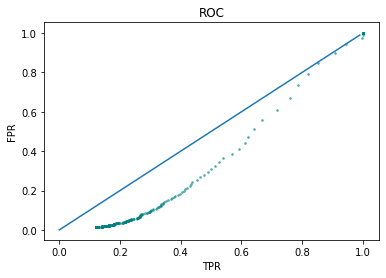

In [133]:
plt.scatter(tpr, fpr, s=3, c=[[0,0.5,0.5]], alpha=0.5)
xlinsp = np.arange(0.0, 1.0, 0.01)
y = xlinsp

plt.plot(xlinsp, y)
plt.title('ROC')
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show()

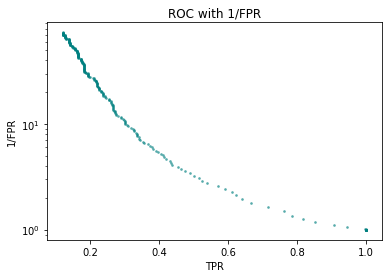

In [124]:
plt.scatter(tpr, 1/fpr, s=3, c=[[0,0.5,0.5]], alpha=0.5)
plt.title('ROC with 1/FPR')
plt.xlabel('TPR')
plt.ylabel('1/FPR')
plt.yscale('log')
plt.show()

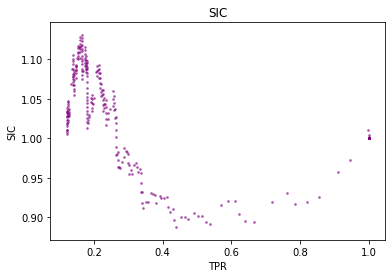

In [136]:
plt.scatter(tpr, tpr/(fpr)**(1/2), s=3, c=[[0.5,0,0.5]], alpha=0.5)
plt.title('SIC')
plt.xlabel('TPR')
plt.ylabel('SIC')
plt.show()